In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h1>Importación de datos</h1>

In [12]:
df = pd.read_csv("emnist_letters_tp.csv", header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Q,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,K,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h1>Analisis exploratorio de datos</h1>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62400 entries, 0 to 62399
Columns: 785 entries, 0 to 784
dtypes: int64(784), object(1)
memory usage: 373.7+ MB


In [5]:
df[0].nunique()

26

In [6]:
df[0].value_counts()

0
F    2400
Q    2400
I    2400
B    2400
X    2400
R    2400
A    2400
G    2400
V    2400
U    2400
Y    2400
M    2400
N    2400
S    2400
Z    2400
P    2400
T    2400
J    2400
E    2400
H    2400
C    2400
O    2400
D    2400
K    2400
W    2400
L    2400
Name: count, dtype: int64

**Cantidad de datos** Hay 62400 filas, cada una con 785 columnas.<br>
**Atributos** Hay 785 atributos, 784 numericos y el primero es un caracter, el indicador de la letra (variable de interes).<br>
**Clase de interes** Hay  26 valores distintos para la clase de interes, todos presentes en igual proporcion.

<h3>Veamos algunos ejemplos de letras</h3>

In [7]:
def flip_rotate(image):
    """
    Función que recibe un array de numpy representando una
    imagen de 28x28. Espeja el array y lo rota en 90°.
    """
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [13]:
Es = df[df[0] == "E"]
Ls = df[df[0] == "L"]
Ms = df[df[0] == "M"]

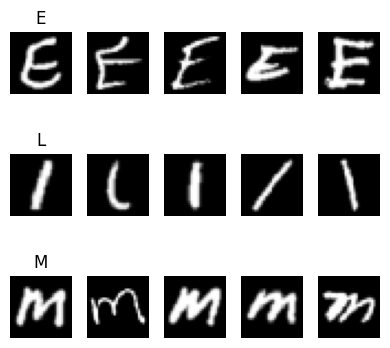

In [14]:
# Definir los dataframes en un diccionario para facilitar el bucle
letras = {'E': Es, 'L': Ls, 'M': Ms}

fig, axs = plt.subplots(3, 5, figsize=(4, 4))  # 3 filas para las letras, 5 columnas para ejemplos de cada letra

for i, (letras, data) in enumerate(letras.items()):
    # Obtener las primeras 5 imágenes del dataframe actual
    for j in range(5):
        row = data.iloc[j].drop(0)
        image_array = np.array(row).astype(np.float32)
        image = flip_rotate(image_array)
        axs[i, j].imshow(image, cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(letras)

plt.tight_layout()
plt.show()

**Veamos las Ces**

<Figure size 640x480 with 0 Axes>

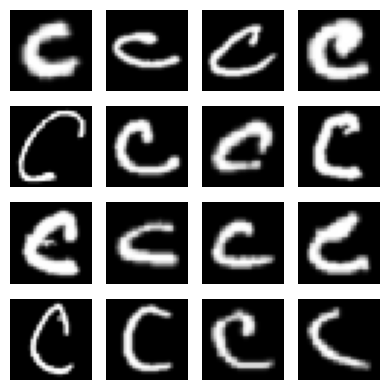

In [21]:
Cs = df[df[0] == "C"]

plt.clf()
fig, axs = plt.subplots(4,4, figsize=(4,4))

for i in range(4):
    for j in range(4):
        random = np.random.randint(0,2399) #elejimos un C al azar
        row = Cs.iloc[random].drop(0)
        image_array = np.array(row).astype(np.float32)
        image = flip_rotate(image_array)
        axs[i, j].imshow(image, cmap='gray')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [16]:
Cs.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
7,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3>Ejercicio 1</h3>
<h3>(a)</h3> Los atributos de los pixeles son la unica informacion que tenemos para predecir la letra correspondiente, por lo que son estos atributos (o columnas) fundamentales para lograr nuestra tarea. Sin embargo se puede notar que los valores correspondientes a las esquinas y bordes de la imagen son en su mayoria igual a cero. Quizas podriamos reducir la cantidad de piexeles por imagen y prescindir de esos datos.<br>
<h3>(b, c)</h3> Las letras no son parecidas, incluso varian mucho las imagenes de una misma letra. Sin embargo cabe notar que si se comparan de a tres (como con la E, la M y la L), se podría decir que hay un par con mas similitudes entre sí. Para el ejemplo arriba visto podemos observar mayores similitudes entre la M y la E, pues ambas presentan un patron de tres rayas, la E hacia la derecha y la M los presenta hacia abajo.<br>
<h3>(d)</h3> En este caso la exploración de datos se debe tomar por otro enfoque, no  se tratará de graficos de caja o de histogramas, ya que no servirian ningún proposito, lo importante en una base de datos de imagenes es poder verlas, ver patrones en ellas, identificar la cantidad de colores tal vez, el tamaño de cada imagen; y por sobre todas las cosas, ver que valores puede tomar cada imagen, para responder la cantidad de posibles valores distintos, y que porcentaje representa cada uno de estos en el conjunto de datos.